In [1]:
import pandas as pd
import sqlite3 
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
from lin_reg import best_line
%matplotlib inline

In [2]:
# Reading in data files

movie_budgets = pd.read_csv('../data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('../data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('../data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')

con = sqlite3.connect('../data/im.db')
schema_imdb = pd.read_sql(
"""
SELECT *
FROM sqlite_master;
""", con)
schema_imdb

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


## Looking at imdb

In [3]:
directors_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() >5;
""", con)
directors_experienced

,person_id
0,nm0000095
1,nm0000108
2,nm0000110
3,nm0000116
4,nm0000123
...,...
9737,nm9983975
9738,nm9985563
9739,nm9986248
9740,nm9987882


In [4]:
directors_not_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() <=5;
""", con)
directors_not_experienced

,person_id
0,nm0000080
1,nm0000118
2,nm0000127
3,nm0000128
4,nm0000136
...,...
99506,nm9993281
99507,nm9993379
99508,nm9993380
99509,nm9993381


In [5]:
writers = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM writers
GROUP BY person_id
HAVING COUNT() >5;
""", con)
writers

,person_id
0,nm0000095
1,nm0000108
2,nm0000116
3,nm0000118
4,nm0000175
...,...
5906,nm9977220
5907,nm9983975
5908,nm9985563
5909,nm9987882


In [6]:
known_for = pd.read_sql(
"""
SELECT *
FROM known_for
""", con)
known_for

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [7]:
movie_ratings = pd.read_sql(
"""
SELECT *
FROM movie_ratings
""", con)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [8]:
movie_akas = pd.read_sql(
"""
SELECT *
FROM movie_akas
""", con)
movie_akas

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [9]:
movie_basics = pd.read_sql(
"""
SELECT *
FROM movie_basics
""", con)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [10]:
principals = pd.read_sql(
"""
SELECT *
FROM principals
WHERE category = 'actor' OR category = 'actress' OR characters != 'None'
GROUP BY person_id
HAVING COUNT() >5
""", con)
principals

,movie_id,ordering,person_id,category,job,characters
0,tt1637702,3,nm0000026,archive_footage,None,"[""Himself""]"
1,tt1979172,2,nm0000092,actor,None,"[""John Cleese"",""Exploding Don"",""David Frost""]"
2,tt1001526,3,nm0000093,actor,None,"[""Metro Man""]"
3,tt1849742,3,nm0000095,self,None,"[""Himself""]"
4,tt1770734,3,nm0000096,actress,None,"[""Kate Fletcher""]"
...,...,...,...,...,...,...
8938,tt2284964,1,nm9575332,actor,None,None
8939,tt4898004,1,nm9706424,actor,None,None
8940,tt8310586,3,nm9779533,actor,None,None
8941,tt10457158,4,nm9799185,actor,None,"[""Kondo""]"


In [11]:
persons = pd.read_sql(
"""
SELECT *
FROM persons
""", con)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


## Getting datasets for experienced vs. not experienced Directors and Writers

In [27]:
#final for data cleaning

d_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() <=3) AS d_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
d_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,39566.000000,39566.000000,39566,39566
unique,NaN,NaN,39566,34106
top,NaN,NaN,nm0888743,"Milano 55,1. Cronaca di una settimana di passioni"
freq,NaN,NaN,1,48
mean,6.515766,909.214224,NaN,NaN
std,1.491461,9040.204720,NaN,NaN
min,1.000000,5.000000,NaN,NaN
25%,5.600000,11.000000,NaN,NaN
50%,6.700000,29.000000,NaN,NaN
75%,7.600000,134.000000,NaN,NaN


In [26]:
d_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_n_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() >3) AS d_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
d_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,12765.000000,1.276500e+04,12765,12765
unique,NaN,NaN,12765,10020
top,NaN,NaN,nm5058168,World of Death
freq,NaN,NaN,1,83
mean,6.159976,5.892464e+03,NaN,NaN
std,1.389006,3.771988e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,2.100000e+01,NaN,NaN
50%,6.300000,8.500000e+01,NaN,NaN
75%,7.100000,5.080000e+02,NaN,NaN


In [28]:
w_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_n_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() <=3) as w_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
w_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,63619.000000,6.361900e+04,63619,63619
unique,NaN,NaN,63619,40989
top,NaN,NaN,nm0753382,Hug an Atheist
freq,NaN,NaN,1,28
mean,6.274442,3.764226e+03,NaN,NaN
std,1.448698,2.859679e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.500000e+01,NaN,NaN
50%,6.400000,5.700000e+01,NaN,NaN
75%,7.300000,3.340000e+02,NaN,NaN


In [29]:
w_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() >3) as w_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
w_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,8434.000000,8.434000e+03,8434,8434
unique,NaN,NaN,8434,5387
top,NaN,NaN,nm3014258,World of Death
freq,NaN,NaN,1,46
mean,6.101672,9.022202e+03,NaN,NaN
std,1.395730,5.134912e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.300000,2.100000e+01,NaN,NaN
50%,6.200000,9.700000e+01,NaN,NaN
75%,7.100000,6.335000e+02,NaN,NaN


In [32]:
# renaming tmdb_movies and tn.movie_budgets title to match primary key from movie_basics merged d_e, w_e, d_n_e, w_n_e data sets
movie_budgets.rename(columns={"movie":"primary_title"}, inplace=True)
tmdb_movies.rename(columns={"title":"primary_title"}, inplace=True)

In [50]:
# experienced directors final data set
# ?Need to drop some columns?
merged_d_e = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_d_e = pd.merge(merged_d_e, movie_budgets, on='primary_title')
merged_d_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,7.6,326657,nm0587955,Moneyball,2505,[18],60308,en,Moneyball,15.393,2011-09-22,7.1,2255,15,"Sep 23, 2011","$50,000,000","$75,605,492","$111,300,835"
1,7.0,85839,nm2648685,Another Earth,2633,"[18, 878]",55420,en,Another Earth,10.030,2011-07-22,6.7,853,48,"Jul 22, 2011","$175,000","$1,321,194","$2,102,779"
2,4.7,59914,nm0001774,Zoolander 2,17483,[35],329833,en,Zoolander 2,12.997,2016-02-12,4.7,1374,64,"Feb 12, 2016","$50,000,000","$28,848,693","$55,348,693"
3,7.2,28994,nm0000776,Chasing Mavericks,5517,[18],82684,en,Chasing Mavericks,6.546,2012-10-26,7.0,329,67,"Oct 26, 2012","$20,000,000","$6,002,756","$8,300,821"
4,5.7,9089,nm0015328,Jumping the Broom,2704,[35],57119,en,Jumping the Broom,8.477,2011-05-06,6.0,103,93,"May 6, 2011","$7,000,000","$37,295,394","$38,158,601"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2.5,54,nm3231736,Plastic,11322,"[18, 28, 35, 80]",208869,en,Plastic,7.815,2014-09-26,6.1,116,39,"Sep 26, 2014","$10,000,000",$0,"$575,371"
723,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,"[28, 27, 878]",173897,en,Resident Evil: The Final Chapter,0.844,2017-01-27,5.9,1859,84,"Jan 27, 2017","$40,000,000","$26,844,692","$314,101,190"
724,7.0,163279,nm0197855,Game Night,23908,"[9648, 35, 80]",445571,en,Game Night,19.459,2018-02-23,6.9,2756,94,"Feb 23, 2018","$37,000,000","$69,179,066","$117,378,084"
725,7.0,163279,nm0326246,Game Night,23908,"[9648, 35, 80]",445571,en,Game Night,19.459,2018-02-23,6.9,2756,94,"Feb 23, 2018","$37,000,000","$69,179,066","$117,378,084"


In [51]:
# non-experienced directors final data set

merged_d_n_e = pd.merge(d_n_e, tmdb_movies, on='primary_title')
merged_d_n_e = pd.merge(merged_d_n_e, movie_budgets, on='primary_title')
merged_d_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,7.0,1613,nm1464150,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
1,6.5,13,nm4418339,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
2,4.4,69199,nm0455078,Sex and the City 2,137,"[35, 18, 10749]",37786,en,Sex and the City 2,9.986,2010-05-27,5.9,809,16,"May 27, 2010","$95,000,000","$95,347,692","$294,680,778"
3,5.6,44490,nm2552536,Don't Be Afraid of the Dark,214,"[14, 27, 53]",46261,en,Don't Be Afraid of the Dark,8.405,2010-11-06,5.5,550,43,"Aug 26, 2011","$25,000,000","$24,046,682","$39,126,427"
4,7.1,129443,nm0002339,Remember Me,92,"[18, 10749]",23169,en,Remember Me,11.453,2010-03-12,7.1,2079,51,"Mar 12, 2010","$16,000,000","$19,068,240","$56,506,120"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,7.7,1165,nm4717106,Phantom,8199,[53],152259,en,Phantom,7.211,2013-03-01,6.0,151,43,"Mar 1, 2013","$18,000,000","$1,034,589","$1,199,510"
1123,5.0,102,nm2670525,8 Days,12875,"[53, 18]",433715,en,8 Days,0.840,2014-06-15,8.0,2,48,"Oct 13, 2015","$2,500,000",$0,$0
1124,6.9,14122,nm0697656,Beyond the Lights,11333,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"
1125,6.9,14122,nm0697656,Beyond the Lights,14469,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"


In [52]:
# experienced writers final data set

merged_w_e = pd.merge(w_e, tmdb_movies, on='primary_title')
merged_w_e = pd.merge(merged_w_e, movie_budgets, on='primary_title')
merged_w_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,8.0,621193,nm1872664,The Revenant,14203,"[37, 18, 12]",281957,en,The Revenant,19.410,2015-12-25,7.4,11064,27,"Dec 25, 2015","$135,000,000","$183,637,894","$532,938,302"
1,8.0,621193,nm1872664,The Revenant,17411,"[37, 18, 12]",281957,en,The Revenant,19.410,2015-12-25,7.4,11064,27,"Dec 25, 2015","$135,000,000","$183,637,894","$532,938,302"
2,7.2,176699,nm0000092,The Croods,7914,"[28, 12, 16, 35, 10751, 14]",49519,en,The Croods,16.290,2013-03-22,6.8,3873,26,"Mar 22, 2013","$135,000,000","$187,168,425","$573,068,425"
3,6.4,6466,nm0119989,Freakonomics,401,[99],43942,en,Freakonomics,5.705,2010-10-01,6.6,57,80,"Oct 1, 2010","$2,900,000","$101,270","$172,867"
4,6.4,6466,nm1164861,Freakonomics,401,[99],43942,en,Freakonomics,5.705,2010-10-01,6.6,57,80,"Oct 1, 2010","$2,900,000","$101,270","$172,867"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,3.1,129,nm1923871,Forsaken,18987,[27],380734,en,Forsaken,1.262,2016-02-02,3.7,15,54,"Feb 19, 2016","$18,000,000",$0,$0
587,3.1,129,nm1923871,Forsaken,22448,[53],461708,es,Forsaken,1.062,2017-06-13,6.6,4,54,"Feb 19, 2016","$18,000,000",$0,$0
588,4.9,632,nm1227232,The Sleepwalker,11910,[18],244776,en,The Sleepwalker,2.659,2014-01-20,4.1,9,2,"Nov 21, 2014","$1,100,000","$2,636","$2,636"
589,6.2,760,nm0502412,Out of the Blue,10024,[28],281697,en,Out of the Blue,0.600,2013-10-01,10.0,1,23,"Oct 19, 2007","$4,600,000",$728,"$731,767"


In [53]:
# non-experienced writers
merged_w_n_e = pd.merge(w_n_e, tmdb_movies, on='primary_title')
merged_w_n_e = pd.merge(merged_w_n_e, movie_budgets, on='primary_title')
merged_w_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,4.2,50352,nm0001317,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
1,4.2,50352,nm0316417,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
2,4.2,50352,nm1048866,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
3,7.0,1613,nm1559624,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
4,7.0,1613,nm1670295,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,6.9,14122,nm0697656,Beyond the Lights,14469,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"
3342,8.2,15,nm1847672,Point Blank,2912,"[28, 53, 80]",61404,fr,À bout portant,6.021,2011-07-29,6.6,230,69,"Sep 18, 1967","$3,000,000",$0,$0
3343,7.4,2724,nm3773554,Teefa in Trouble,24815,"[18, 35, 28, 80]",506971,ur,Teefa in Trouble,4.486,2018-07-20,7.6,11,8,"Jul 20, 2018","$1,500,000",$0,"$98,806"
3344,7.4,2724,nm6511211,Teefa in Trouble,24815,"[18, 35, 28, 80]",506971,ur,Teefa in Trouble,4.486,2018-07-20,7.6,11,8,"Jul 20, 2018","$1,500,000",$0,"$98,806"


## Hypo tests for experienced vs. non-experienced d's and w's

## Getting datasets for runtime and budget

In [ ]:
movie_budgets.rename(columns={"movie":"primary_title"}, inplace=True)

In [ ]:
movie_budgets.info()

In [ ]:
movie_basics.info()

In [57]:
movie_basics_budget = pd.merge(movie_budgets, movie_basics, how ='inner', on='primary_title')
movie_basics_budget = pd.merge(movie_basics_budget, tmdb_movies, how ='inner', on='primary_title')
movie_basics_budget 

,id_x,release_date_x,primary_title,production_budget,domestic_gross,worldwide_gross,movie_id,original_title_x,start_year,runtime_minutes,genres,Unnamed: 0,genre_ids,id_y,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,Abatâ,2011,93.0,Horror,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,7.4,18676
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,6.4,8571
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,7.3,13457
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,8.3,13948
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",tt0974015,Justice League,2017,120.0,"Action,Adventure,Fantasy",20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,51,"Apr 21, 2015",Ten,"$25,000",$0,$0,tt2496400,Ten,2014,83.0,"Adventure,Horror,Mystery",12326,"[12, 27, 9648, 53]",279516,en,Ten,1.575,2014-03-28,5.4,5
4546,51,"Apr 21, 2015",Ten,"$25,000",$0,$0,tt6415838,Ten,2017,82.0,"Horror,Mystery,Thriller",12326,"[12, 27, 9648, 53]",279516,en,Ten,1.575,2014-03-28,5.4,5
4547,54,"Dec 31, 2014",Dry Spell,"$22,000",$0,$0,tt2375036,Dry Spell,2013,90.0,"Comedy,Romance",10470,"[35, 10749]",255266,en,Dry Spell,0.600,2013-02-14,6.0,1
4548,56,"Jan 4, 2013",All Superheroes Must Die,"$20,000",$0,$0,tt1836212,All Superheroes Must Die,2011,78.0,"Sci-Fi,Thriller",8893,"[878, 53]",86304,en,All Superheroes Must Die,2.078,2013-01-04,3.9,19


In [58]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_x               4550 non-null   int64  
 1   release_date_x     4550 non-null   object 
 2   primary_title      4550 non-null   object 
 3   production_budget  4550 non-null   object 
 4   domestic_gross     4550 non-null   object 
 5   worldwide_gross    4550 non-null   object 
 6   movie_id           4550 non-null   object 
 7   original_title_x   4549 non-null   object 
 8   start_year         4550 non-null   int64  
 9   runtime_minutes    4088 non-null   float64
 10  genres             4474 non-null   object 
 11  Unnamed: 0         4550 non-null   int64  
 12  genre_ids          4550 non-null   object 
 13  id_y               4550 non-null   int64  
 14  original_language  4550 non-null   object 
 15  original_title_y   4550 non-null   object 
 16  popularity         4550 

In [59]:
movie_basics_budget['runtime_minutes'].head()

0     93.0
1    136.0
2    141.0
3    149.0
4    120.0
Name: runtime_minutes, dtype: float64

In [103]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

In [93]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)

movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace('$','')
movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace(',','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace('$','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace(',','')


In [62]:
movie_basics_budget = movie_basics_budget[movie_basics_budget['domestic_gross'] != 0].copy()

## Hypo Tests + Regressions for runtime and budget

In [95]:
x = movie_basics_budget['runtime_minutes']
x1 = movie_basics_budget['production_budget'].values.astype(int)
y = movie_basics_budget['worldwide_gross'].values.astype(int)
y1 = movie_basics_budget['popularity']
y2 = movie_basics_budget['vote_average']

# runtime vs. gross test
result = stats.ttest_ind(x, y, equal_var=False)
result

Ttest_indResult(statistic=-33.86922160608614, pvalue=7.465685926947478e-222)

In [94]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

In [87]:
movie_basics_budget['worldwide_gross'].isna().sum()

0

In [88]:
movie_basics_budget['production_budget'].isna().sum()

0

In [90]:
movie_basics_budget['popularity'].isna().sum()

0

In [89]:
movie_basics_budget['vote_average'].isna().sum()

0

In [96]:
# runtime vs. popularity test
result2 = stats.ttest_ind(x, y1, equal_var=False)
result2

Ttest_indResult(statistic=97.7142099616606, pvalue=0.0)

In [98]:
# runtime vs. vote_average test
result3 = stats.ttest_ind(x, y2, equal_var=False)
result3

Ttest_indResult(statistic=106.80026010916458, pvalue=0.0)

In [99]:
# budget vs. gross test
result4 = stats.ttest_ind(x1, y, equal_var=False)
result4

Ttest_indResult(statistic=-22.250526813161205, pvalue=3.327923363291706e-104)

In [100]:
# budget vs. popularity test
result5 = stats.ttest_ind(x1, y1, equal_var=False)
result5

Ttest_indResult(statistic=45.93238593185758, pvalue=0.0)

In [101]:
# budget vs. vote_average test
# ?? getting same result for this as budget vs. popularity
result6 = stats.ttest_ind(x1, y2, equal_var=False)
result6

Ttest_indResult(statistic=45.93238876822305, pvalue=0.0)

<AxesSubplot:>

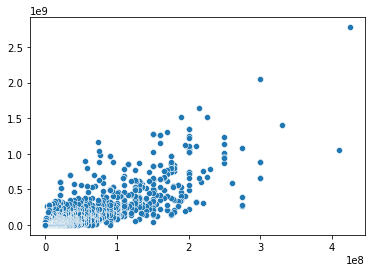

In [102]:
sns.scatterplot(x=x1, y=y)

<AxesSubplot:xlabel='runtime_minutes'>

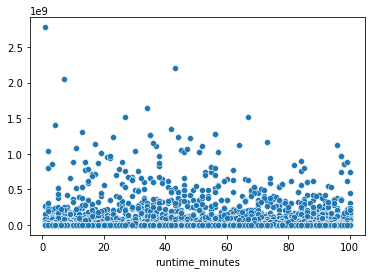

In [43]:
sns.scatterplot(x=x, y=y)

In [44]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 0 to 3814
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3328 non-null   int64 
 1   release_date       3328 non-null   object
 2   primary_title      3328 non-null   object
 3   production_budget  3328 non-null   object
 4   domestic_gross     3328 non-null   object
 5   worldwide_gross    3328 non-null   object
 6   movie_id           3328 non-null   object
 7   original_title     3328 non-null   object
 8   start_year         3328 non-null   int64 
 9   runtime_minutes    3328 non-null   object
 10  genres             3309 non-null   object
dtypes: int64(2), object(9)
memory usage: 312.0+ KB


In [45]:
x = sm.add_constant(movie_basics_budget['runtime_minutes'].values.astype(int))
x1 = sm.add_constant(movie_basics_budget['production_budget'].values.astype(int))
y = movie_basics_budget['worldwide_gross'].values.astype(int)

In [46]:
lin_reg_model = sm.OLS(y, x1).fit().summary()
lin_reg_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     4990.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:07:00   Log-Likelihood:                -66742.
No. Observations:                3328   AIC:                         1.335e+05
Df Residuals:                    3326   BIC:                         1.335e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.144e+07   2.65e+06     -4.318      0.000   -1.66e+07   -6.24e+06
x1             3.2805      0.046     70.643      0.000       3.189       3.372
==============================================================================
Omnibus:                     2337.757   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97115.258
Skew:                           2.828   Prob(JB):                         0.00
Kurtosis:                      28.852   Cond. No.                     7.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
lin_reg_model_2 = sm.OLS(y, x).fit().summary()
lin_reg_model_2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3544
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.552
Time:                        17:07:18   Log-Likelihood:                -68266.
No. Observations:                3328   AIC:                         1.365e+05
Df Residuals:                    3326   BIC:                         1.365e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.015e+08   6.92e+06     14.665      0.000    8.79e+07    1.15e+08
x1          -7.08e+04   1.19e+05     -0.595      0.552   -3.04e+05    1.62e+05
==============================================================================
Omnibus:                     3078.681   Durbin-Watson:                   0.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128708.635
Skew:                           4.409   Prob(JB):                         0.00
Kurtosis:                      32.162   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
movie_gross.info()

## Looking at movie_budgets

In [ ]:
zero_gross = movie_budgets.loc[movie_budgets['domestic_gross'] == 0]
zero_gross

In [ ]:
movie_budgets.head()

In [ ]:
movie_budgets.rename(columns={"movie":"primary_title"})

In [ ]:
movie_budgets.info()

In [ ]:
movie_budgets.describe(include='all')

## Looking at tmdb_movies

In [ ]:
tmdb_movies.head()

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.describe(include='all')

## Looking at rt_reviews

In [ ]:
rt_reviews.head()

In [ ]:
rt_reviews.info()

In [ ]:
rt_reviews.describe(include='all')

## Looking at rt_movie_info

In [ ]:
rt_movie_info.head()

In [ ]:
rt_movie_info.info()

In [ ]:
rt_movie_info.describe(include='all')

## Looking at movie_gross

In [ ]:
movie_gross.head()

In [ ]:
movie_gross.info()

In [ ]:
movie_gross.describe(include='all')

In [ ]:
groupby = movie_gross.groupby('studio').mean()
groupby.sort_values('domestic_gross', ascending=False)

In [ ]:
lin_reg_model_3 = sm.OLS(y, x1).fit().summary()
